# Feature Selection

In an effort to reduce the dimensionality of our dataset, we need to know which features are more meaningful than others, so that we can drop the less meaningful ones.
We might also attempt to combine features, extract other features from the ones we already have, and more.

In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from proj1_helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Data loading
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Correlation to the output

If we look at how much each feature correlates to the output, we can rank them by meaning

feature  0 :  0.23914905789154473
feature  1 :  -0.3514279558616751
feature  2 :  -0.014055273784852506
feature  3 :  0.19252632856874796
feature  4 :  0.1416459925656641
feature  5 :  0.19176608807477077
feature  6 :  0.14055440046509557
feature  7 :  0.012245481285482902
feature  8 :  -0.015287426687781413
feature  9 :  0.1532359324758135
feature  10 :  -0.19539789618287817
feature  11 :  0.2717518770516493
feature  12 :  0.14134598859646297
feature  13 :  0.23523797587836723
feature  14 :  -0.0009432510582117487
feature  15 :  -0.0044025386863883985
feature  16 :  -0.031947586805348205
feature  17 :  0.0015162353770597236
feature  18 :  0.0041254474115248515
feature  19 :  0.02246575151078583
feature  20 :  0.0074753421885902374
feature  21 :  0.1355202615226846
feature  22 :  0.13354912308169134
feature  23 :  0.15760414567634926
feature  24 :  0.15046926004977906
feature  25 :  0.15046803779292678
feature  26 :  0.1407143669504368
feature  27 :  0.1412649137760153
feature  28 :  0

<BarContainer object of 30 artists>

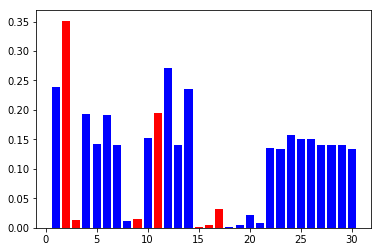

In [6]:
correlation_scores = []

for i in range(tX.shape[1]): #for each feature
    #extract feature
    feature = tX[:,i]
    #correlate with output
    correlation_matrix = np.corrcoef(feature, y)
    #keep only the correlation between x and y
    correlation_coef = correlation_matrix[0,1]
    correlation_scores.append(correlation_coef)
    
    print("feature ", i, ": ", correlation_coef)
    
    
absolute_corr_scores = [abs(corr) for corr in correlation_scores]

sign_corr_scores = []
sign_corr_color = []
for i in range(len(correlation_scores)):
    sign = correlation_scores[i]/absolute_corr_scores[i]
    if sign == 1:
        sign_corr_color.append('b')
    else:
        sign_corr_color.append('r')
        
    sign_corr_scores.append(sign)

plt.bar(np.linspace(1,30,30),absolute_corr_scores, color=sign_corr_color)

Bars in blue have positive correlation, and bars in red have negative correlation.
We see that none of the features have a particularly high correlation coefficient (max absolute value around 0.35, max possible is 1), but some of them have a very low correlation. Those low correlation (<0.05) features are:
- feature 03: DER mass vis
- feature 08: DER deltar tau lep
- feature 09: DER pt tot
- feature 15: PRI tau eta
- feature 16: PRI tau phi
- feature 17: PRI lep pt
- feature 18: PRI lep eta
- feature 19: PRI lep phi
- feature 20: PRI met
- feature 21: PRI met phi

Deleting them would reduce the dimensionality of our dataset from 30 to 20 dimensions, a very high decrease.

In [7]:
#reload data so that we do not accidentally delete features multiple times
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

features_to_delete = [2, 7, 8, 14, 15, 16, 17, 18, 19, 20] #list derived from conclusions above

tX_reduced = np.delete(tX, features_to_delete, axis=1) #delete the features
tX_reduced.shape

(250000, 20)

## Correlation between features
Another way to reduce dimensionality would be to see which features are correlated, so that we might combine or remove highly correlated features, since their data would be highly redundant.

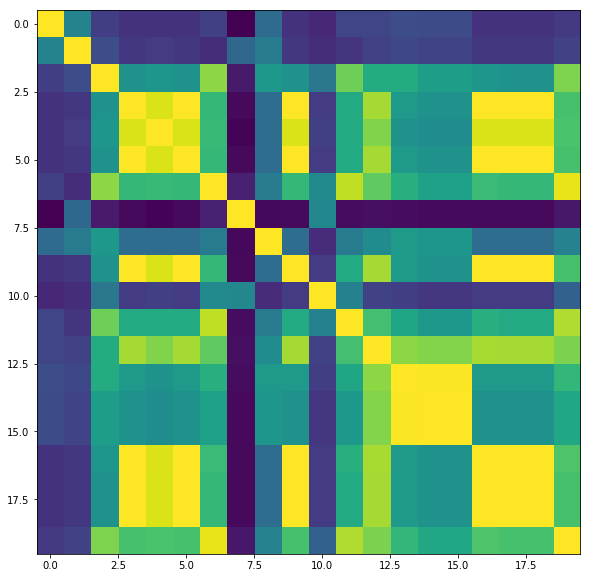

In [8]:
correlation_scores = np.empty([20,20])
absolute_corr_scores = np.empty([20,20])

for i in range(tX_reduced.shape[1]): #for each feature
    #extract feature
    feature1 = tX_reduced[:,i]
    
    for j in range(tX_reduced.shape[1]): # correlate with every other feature
        feature2 = tX_reduced[:,j]

        correlation_matrix = np.corrcoef(feature1, feature2)
        #keep only the correlation between the two features
        correlation_coef = correlation_matrix[0,1]
        correlation_scores[i,j] = correlation_coef
        absolute_corr_scores[i,j] = abs(correlation_coef)
    

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(absolute_corr_scores)

Yellow is high correlation, purple is low correlation. There are a bunch of highly correlated pairs. Let's see which of them have a correlation coefficient higher than 0.95

In [9]:
high_corr_pairs = []
for i in range(len(absolute_corr_scores)):
    for j in range(len(absolute_corr_scores)):
        if absolute_corr_scores[i,j] > 0.95 and i < j:
            high_corr_pairs.append((i,j, absolute_corr_scores[i,j]))
high_corr_pairs

[(3, 5, 0.9999814276833766),
 (3, 9, 0.9999983857136875),
 (3, 16, 0.9993463699208743),
 (3, 17, 0.9999949302305683),
 (3, 18, 0.9999955433879205),
 (5, 9, 0.9999896746909273),
 (5, 16, 0.9993465738419871),
 (5, 17, 0.99998797779375),
 (5, 18, 0.9999886069465257),
 (6, 19, 0.9656283889164003),
 (9, 16, 0.9993546311799896),
 (9, 17, 0.9999969759820075),
 (9, 18, 0.999997556572974),
 (13, 14, 0.9961000122626177),
 (13, 15, 0.9960997956740809),
 (14, 15, 0.999991836893143),
 (16, 17, 0.9993523477702619),
 (16, 18, 0.9993518514848263),
 (17, 18, 0.9999947740006581)]

Except for the pair of features 6 and 19, all of those have a correlation basically equal to 1. Of those, we could keep only the first feature of the tuple, meaning we would keep:
- feature 3
- feature 5 -> can be removed since 3 and 5 are correlated
- feature 6
- feature 9 -> can be removed since 3 and 9 are correlated
- feature 13 
- feature 14 -> can be removed since 13 and 14 are correlated
- feature 16 -> can be removed since 3 and 16 are correlated
- feature 17 -> can be removed since 3 and 17 are correlated
- feature 19 -> let's assume 0.96 is not enough to discard the feature

So we can remove the following features:
- feature 5: DER mass jet jet
- feature 9: DER met phi centrality
- feature 14: PRI jet leading pt
- feature 15: PRI jet leading eta
- feature 16: PRI jet leading phi
- feature 17: PRI jet subleading pt
- feature 18: PRI jet subleading eta

In [10]:
#reload data so that we do not accidentally delete features multiple times
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

features_to_delete = [2, 7, 8, 14, 15, 16, 17, 18, 19, 20] # list from correlation to output
additional_features_to_delete = [4, 8, 13, 14, 15, 16, 17] # additional list from correlation between features

tX_reduced = np.delete(tX, features_to_delete, axis=1) #delete the features
tX_reduced = np.delete(tX_reduced, additional_features_to_delete, axis=1)
tX_reduced.shape

(250000, 13)

## Correlation conclusion

Now that we have reduced the dimensionality of our dataset from 30 to 13, let's have a look at the correlation to the output, the correlation to feature matrix, and the remaining feature.

feature  0 :  0.23914905789154473
feature  1 :  -0.3514279558616751
feature  2 :  0.19252632856874796
feature  3 :  0.1416459925656641
feature  4 :  0.14055440046509557
feature  5 :  0.1532359324758135
feature  6 :  -0.19539789618287817
feature  7 :  0.14134598859646297
feature  8 :  0.23523797587836723
feature  9 :  0.1355202615226846
feature  10 :  0.13354912308169134
feature  11 :  0.14125568650533774
feature  12 :  0.13429572666925302


<BarContainer object of 13 artists>

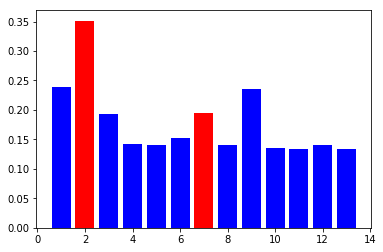

In [11]:
correlation_scores = []

for i in range(tX_reduced.shape[1]): #for each feature
    #extract feature
    feature = tX_reduced[:,i]
    #correlate with output
    correlation_matrix = np.corrcoef(feature, y)
    #keep only the correlation between x and y
    correlation_coef = correlation_matrix[0,1]
    correlation_scores.append(correlation_coef)
    
    print("feature ", i, ": ", correlation_coef)
    
    
absolute_corr_scores = [abs(corr) for corr in correlation_scores]

sign_corr_scores = []
sign_corr_color = []
for i in range(len(correlation_scores)):
    sign = correlation_scores[i]/absolute_corr_scores[i]
    if sign == 1:
        sign_corr_color.append('b')
    else:
        sign_corr_color.append('r')
        
    sign_corr_scores.append(sign)

plt.bar(np.linspace(1,13,13),absolute_corr_scores, color=sign_corr_color)

We see that all of our remaining features have a correlation to the output above 10%.

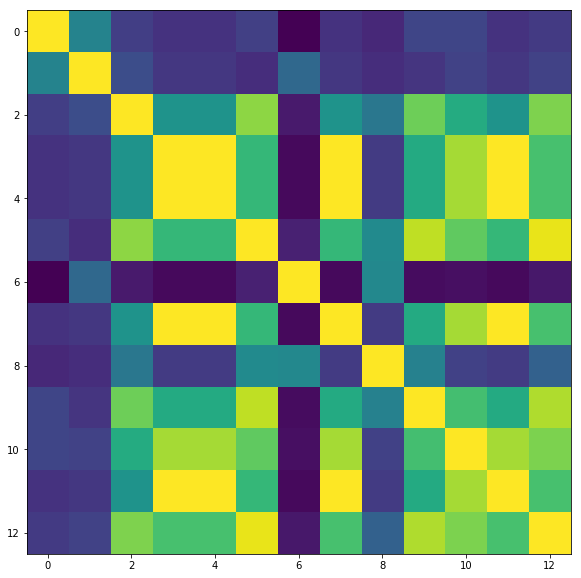

In [12]:
correlation_scores = np.empty([13,13])
absolute_corr_scores = np.empty([13,13])

for i in range(tX_reduced.shape[1]): #for each feature
    #extract feature
    feature1 = tX_reduced[:,i]
    
    for j in range(tX_reduced.shape[1]): # correlate with every other feature
        feature2 = tX_reduced[:,j]

        correlation_matrix = np.corrcoef(feature1, feature2)
        #keep only the correlation between the two features
        correlation_coef = correlation_matrix[0,1]
        correlation_scores[i,j] = correlation_coef
        absolute_corr_scores[i,j] = abs(correlation_coef)
    

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(absolute_corr_scores)

For some reason, we still have some highly correlated features that didn't show in the previous test, we might be better off leaving them in.

## Further selection

Some of our remaining features still have undefined values. For now, it is not clear what we should do with them.
On the exception of feature 1 DER mass MMC, the feature with exceptions are ruled by feature 11 jet num:
if jetnum <= 1, then the data point is undefined for features 4, 5, 8, 12.

Here are a few possibilities to proceed with that:
- Keep the dataset that way, the model might just manage the undefined values
- Remove all data points in every feature where jetnum <= 1, leaving us with all 13 features but less data points (we'd be left with around 70'000 data points instead of the provided 250'000, a very large reduction)
- Remove the features that have undefined values, leaving us with 9 features total
- Give the undefined data points a value more manageable than -999

For now, I would advocate to just let the model deal with it and to see what happens.

# Results and conclusion

The following load function was written, in order to load reduced data. It is based on the results of the output correlation step and the feature correlation step.

In [13]:
from misc_helpers import *
y, tX, ids = load_reduced_training_data(DATA_TRAIN_PATH, delete_low_output_correlation=True, delete_high_feature_correlation=True)
tX.shape

(250000, 13)

It might be a good idea to test the model with the whole dataset, then with low output correlation removed, then with both removed to see if the results improve as expected. Then, it might be useful to think about the undefined values, as discussed in the previous section

# Feature Selection Validation

Let's see if those theoretical results are any good

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from proj1_helpers import *
from implementations import *
from misc_helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Without feature selection

In [29]:
y, tX, ids = load_reduced_training_data(DATA_TRAIN_PATH, delete_low_output_correlation=False, delete_high_feature_correlation=False)
y_norm = normalize(y)
tX_norm = normalize(tX)

#test
DATA_TEST_PATH = "../data/test.csv"
y, tX, ids = load_csv_data(DATA_TEST_PATH)
y_norm_t = normalize(y)
tX_norm_t = normalize(tX)

In [30]:
w = np.zeros([tX.shape[1]])

#train
w_final, loss = least_squares_GD(y_norm, tX_norm, w)
print("Train loss: ", loss)

Train loss:  1.9977292160664303e-06


In [32]:
test_loss = compute_MSE(y_norm_t, tX_norm_t, w_final)
print("Test loss: ", test_loss)

Test loss:  8.823747409713217e-07


## Deleting low output correlation features

In [36]:
y, tX, ids = load_reduced_training_data(DATA_TRAIN_PATH, delete_low_output_correlation=True, delete_high_feature_correlation=False)
y_norm = normalize(y)
tX_norm = normalize(tX)

#test
DATA_TEST_PATH = "../data/test.csv"
y, tX, ids = load_reduced_training_data(DATA_TEST_PATH, delete_low_output_correlation=True, delete_high_feature_correlation=False)
y_norm_t = normalize(y)
tX_norm_t = normalize(tX)

In [37]:
w = np.zeros([tX.shape[1]])

#train
w_final, loss = least_squares_GD(y_norm, tX_norm, w)
print("Train loss: ", loss)

Train loss:  1.9981242092758316e-06


In [38]:
test_loss = compute_MSE(y_norm_t, tX_norm_t, w_final)
print("Test loss: ", test_loss)

Test loss:  8.818182086036881e-07


## Also deleting highly correlated features

In [39]:
y, tX, ids = load_reduced_training_data(DATA_TRAIN_PATH, delete_low_output_correlation=True, delete_high_feature_correlation=True)
y_norm = normalize(y)
tX_norm = normalize(tX)

#test
DATA_TEST_PATH = "../data/test.csv"
y, tX, ids = load_reduced_training_data(DATA_TEST_PATH, delete_low_output_correlation=True, delete_high_feature_correlation=True)
y_norm_t = normalize(y)
tX_norm_t = normalize(tX)

In [40]:
w = np.zeros([tX.shape[1]])

#train
w_final, loss = least_squares_GD(y_norm, tX_norm, w)
print("Train loss: ", loss)

Train loss:  1.9989081833827053e-06


In [41]:
test_loss = compute_MSE(y_norm_t, tX_norm_t, w_final)
print("Test loss: ", test_loss)

Test loss:  8.811404740079968e-07


We see that there is no significant change in loss quality when using the partly or completely reduced dataset, which means our feature selection worked, we can get rid of the unused features.